## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## 1.  compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from matplotlib.image import imsave as mpsave
from matplotlib.image import imread as mpread
%matplotlib qt

def get_calibration_mtx():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('../camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = mpread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            cv2.imshow('img',img)
            cv2.waitKey(500)

    cv2.destroyAllWindows()
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return mtx, dist

### Computer camera calibration matrix, and store it

In [2]:
%matplotlib qt
mtx, dist = get_calibration_mtx()

import pickle
with open('dump.pkl', 'wb') as f:
    pickle.dump(
        {
            'mtx': mtx,
            'dist': dist,
        }, f, pickle.HIGHEST_PROTOCOL)

### reload the previously loaded calibration result

In [2]:
import pickle
with open('dump.pkl', 'rb') as f:
    pickle_data = pickle.load(f)
    mtx = pickle_data['mtx']
    dist = pickle_data['dist']

## 2. use the calibration for new image testing  

In [3]:
%matplotlib inline
import numpy as np

def testimg_calibration(mtx, dist):
    images = glob.glob('../camera_cal/calibration*.jpg')
    testidx = np.random.randint(0, len(images))
    print('test on image file ', images[testidx])
    img = mpread(images[testidx])

    dst = cv2.undistort(img, mtx, dist, None, mtx)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(dst)
    ax2.set_title('Undistorted Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

test on image file  ../camera_cal\calibration15.jpg


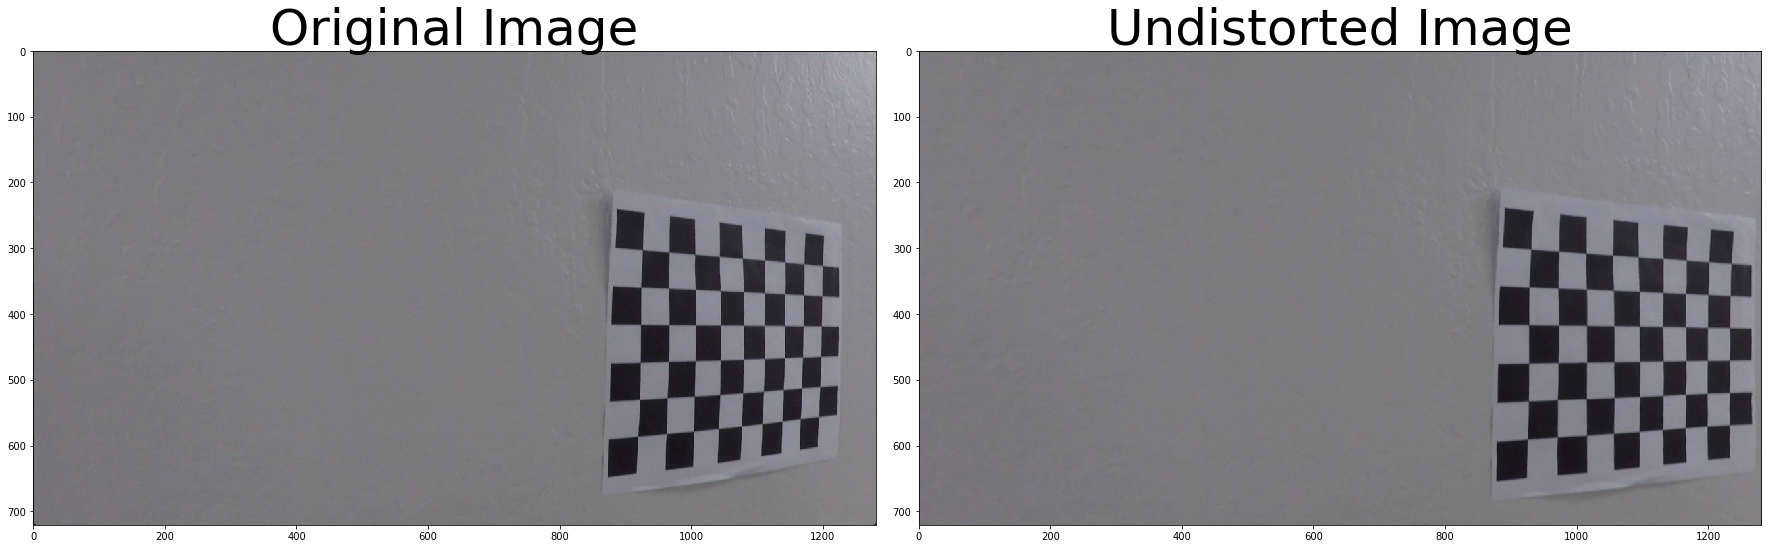

In [4]:
testimg_calibration(mtx, dist)


## 3 Apply a perspective transform to rectify binary image ("birds-eye view").
find a proper image to do the perspective transform


In [5]:
import os
%matplotlib inline
def get_perspective_transform_mtx():
    pers_img = os.path.join('..', 'test_images', 'straight_lines1.jpg')
    print(pers_img)
    img = mpread(pers_img)
    plt.imshow(img)
    src = np.float32([[560, 460], [720, 460], [1250, 720], [40, 720]])
    dst = np.float32([[100, 0], [1060, 0], [1060, 700], [100, 700]])
        
    src = np.float32([[490, 482],[810, 482], [1250, 720],[0, 720]])
    dst = np.float32([[0, 0], [1280, 0], [1250, 720],[40, 720]])
    '''
          0   1
           ---
          /   \
         /     \
        /       \
        ---------
       3         2 
    '''
    plt.plot(*src[0], '.', color = 'r')
    plt.plot(*src[1], '.', color = 'r')
    plt.plot(*src[2], '.', color = 'r')
    plt.plot(*src[3], '.', color = 'r')
    plt.plot(*dst[0], 'x', color = 'y')
    plt.plot(*dst[1], 'x', color = 'y')
    plt.plot(*dst[2], 'x', color = 'y')
    plt.plot(*dst[3], 'x', color = 'y')

    # computer the perspective transformation matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv


### calculate perspective transformation info and save them in a pickle file

..\test_images\straight_lines1.jpg


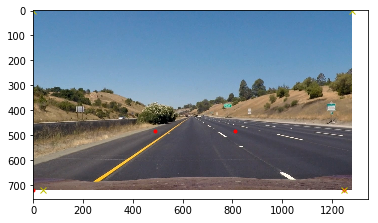

In [6]:
M, Minv = get_perspective_transform_mtx()

import pickle
with open('dump2.pkl', 'wb') as f:
    pickle.dump(
        {
            'M': M,
            'Minv': Minv,
        }, f, pickle.HIGHEST_PROTOCOL)

### reload perspective transformation info from previously saved pickle file


In [7]:
import pickle
with open('dump2.pkl', 'rb') as f:
    pickle_data = pickle.load(f)
    M = pickle_data['M']
    Minv = pickle_data['Minv']

test and check the perspective transformation

In [8]:
import os
def testimg_perspective_transform(m, imgidx = 1):
    # do transformation on the test image
    # check the final warped image after perspective transformation
    imgname = os.path.join('..', 'test_images', 'straight_lines' + str(imgidx) + '.jpg')
    print(imgname)
    img = mpread(imgname)    
    img_size = img.shape[1], img.shape[0]
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    plt.imshow(warped)


..\test_images\straight_lines1.jpg


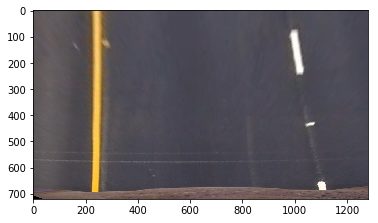

In [9]:
testimg_perspective_transform(M, imgidx = 1)   

..\test_images\straight_lines2.jpg


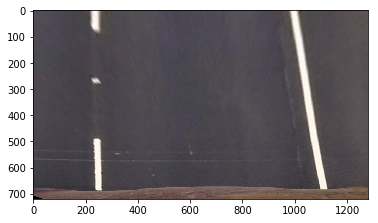

In [10]:
testimg_perspective_transform(M, imgidx = 2)  

## 4. Use color transforms, gradients, etc., to create a thresholded binary image.
define a function called bin img selection

In [11]:
from cv2 import Sobel
def build_binary_img(img, rawtype = 'rgb', channeltype = 'gray', gradient = None, thresh = (170, 255)):
    if rawtype == 'rgb':
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        rgb = img
        luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    elif rawtype == 'bgr':
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        luv = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
    else:
        assert 0, 'rawtype should be bgr or rgb'
    
    channelname = channeltype.lower()
    if channelname ==  'gray':
        channel = gray
    elif channelname == 'rgb_r':
        channel = rgb[:,:,0]
    elif channelname == 'rgb_g':
        channel = rgb[:,:,1]
    elif channelname == 'rgb_b':
        channel = rgb[:,:,2]
    elif channelname == 'hls_h':
        channel = hls[:,:,0]
    elif channelname == 'hls_l':
        channel = hls[:,:,1]
    elif channelname == 'hls_s':
        channel = hls[:,:,2]
    elif channelname == 'luv_l':
        channel = luv[:, :, 0]
    elif channelname == 'luv_u':
        channel = luv[:, :, 1]
    elif channelname == 'luv_v':
        channel = luv[:, :, 2]
    elif channelname == 'lab_l':
        channel = lab[:, :, 0]
    elif channelname == 'lab_a':
        channel = lab[:, :, 1]
    elif channelname == 'lab_b':
        channel = lab[:,:,2]
    else:
        assert 0, 'channel name ' + channelname + ' not valid'
        
    if gradient != None:
        if gradient.lower() == 'x':
            newimg = Sobel(channel, cv2.CV_64F, 1, 0)
        else:
            newimg = Sobel(channel, cv2.CV_64F, 0, 1)
        newimg = np.absolute(newimg)
        newimg = np.int8(255 * newimg / np.max(newimg))
    else:
        newimg = channel
    
    result = np.zeros_like(newimg)
    result[(newimg >= thresh[0]) & (newimg <= thresh[1])] = 1
    return result


def combine_imgs(bin_img1, bin_img2):
    assert bin_img1.shape == bin_img2.shape
    combined = np.zeros_like(bin_img1)
    combined[(bin_img1 > 0) | (bin_img2 > 0)] = 1
    return combined

def gray_img(bin_img):
    return bin_img * 255

def build_gray_img(color_img, rawtype, channeltype ):
    assert rawtype == 'rgb' or rawtype == 'bgr', 'raw type should be rgb or bgr'
    if  channeltype in ['rgb_r', 'rgb_g', 'rgb_b'] and rawtype == 'bgr':
        if channeltype == 'rgb_r':
            return color_img[:,:,2]
        elif channeltype == 'rgb_g':
            return color_img[:,:,1]
        else:
            return color_img[:,:,0]
    elif channeltype in ['rgb_r', 'rgb_g', 'rgb_b'] and rawtype == 'rgb':
        if channeltype == 'rgb_r':
            return color_img[:,:,0]
        elif channeltype == 'rgb_g':
            return color_img[:,:,1]
        else:
            return color_img[:,:,2]
    elif channeltype in ['hls_h', 'hls_l', 'hls_s']:
        if rawtype == 'bgr':
            img = cv2.cvtColor(color_img, cv2.COLOR_BGR2HLS)
        elif rawtype == 'rgb':
            img = cv2.cvtColor(color_img, cv2.COLOR_RGB2HLS)
            
        if channeltype == 'hls_h':
            return img[:, :, 0]
        elif channeltype == 'hls_l':
            return img[:, :, 1]
        else:
            return img[:, :, 2]
    elif channeltype == 'gray':
        if rawtype == 'rgb':
            return cv2.cvtColor(color_img, cv2.COLOR_RGB2GRAY)
        elif rawtype == 'bgr':
            return cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY)

### test build_binary_img function

In [12]:
import os
def testimg_build_binary(picidx = 6):
    
    imgname = os.path.join('..', 'test_images', 'test' + str(picidx)+'.jpg')
    print('testing the binary img build function on image: ', imgname)
    imgraw = mpread(imgname)
    
    img_undistort = cv2.undistort(imgraw, mtx, dist, None, mtx)
    img = cv2.warpPerspective(img_undistort, M, (img_undistort.shape[1], img_undistort.shape[0]), flags=cv2.INTER_LINEAR)
    
    img01 = build_binary_img(img, rawtype = 'rgb', channeltype = 'gray', thresh = (210,255))
    img02 = build_binary_img(img, rawtype = 'rgb', channeltype = 'gray', gradient = 'x', thresh= (50, 100))
    img03 = build_gray_img(img, rawtype = 'rgb',   channeltype = 'gray')
    
    img04 = build_binary_img(img, rawtype = 'rgb', channeltype = 'rgb_r', thresh = (200, 255))
    img05 = build_binary_img(img, rawtype = 'rgb', channeltype = 'rgb_r', gradient = 'x', thresh= (40, 100))
    img06 = build_gray_img(img, rawtype = 'rgb',   channeltype = 'rgb_r')
    
    img07 = build_binary_img(img, rawtype = 'rgb', channeltype = 'rgb_g')
    img08 = build_binary_img(img, rawtype = 'rgb', channeltype = 'rgb_g', gradient = 'x', thresh= (20, 100))
    img09 = build_gray_img(img, rawtype = 'rgb',   channeltype = 'rgb_g')
    
    img10 = build_binary_img(img, rawtype = 'rgb', channeltype = 'rgb_b', thresh = (155, 200))
    img11 = build_binary_img(img, rawtype = 'rgb', channeltype = 'rgb_b', gradient = 'x', thresh= (20, 100))
    img12 = build_gray_img(img, rawtype = 'rgb',   channeltype = 'rgb_b')
    
    img13 = build_binary_img(img, rawtype = 'rgb', channeltype = 'hls_h')
    img14 = build_binary_img(img, rawtype = 'rgb', channeltype = 'hls_h', gradient = 'x', thresh= (20, 100))
    img15 = build_gray_img(img, rawtype = 'rgb',   channeltype = 'hls_h')
    
    img16 = build_binary_img(img, rawtype = 'rgb', channeltype = 'hls_l', thresh = (200, 255))
    img17 = build_binary_img(img, rawtype = 'rgb', channeltype = 'hls_l', gradient = 'x', thresh= (20, 100))
    img18 = build_gray_img(img, rawtype = 'rgb',   channeltype = 'hls_l')
    
    img19 = build_binary_img(img, rawtype = 'rgb', channeltype = 'hls_s', thresh = (180, 255))
    img20 = build_binary_img(img, rawtype = 'rgb', channeltype = 'hls_s', gradient = 'x', thresh= (20, 100))
    img21 = build_gray_img(img, rawtype = 'rgb',   channeltype = 'hls_s')
    
    img22 = build_binary_img(img, rawtype = 'rgb',   channeltype = 'luv_l', thresh = (225, 255))
    img23 = build_binary_img(img, rawtype = 'rgb',   channeltype = 'lab_b', thresh = (155, 200))
    
    f, ax = plt.subplots(9, 3, figsize=(48, 98))
    f.tight_layout()
   
    
    ax[0][0].imshow(imgraw)
    ax[0][0].set_title('Original Image', fontsize=32)
    
    ax[0][1].imshow( img_undistort)
    ax[0][1].set_title('undistorted Image', fontsize=32)
    
    ax[0][2].imshow(img)
    ax[0][2].set_title('warp perspective img', fontsize=32)    


    ax[1][0].imshow(gray_img(img01), cmap = 'gray')
    ax[1][0].set_title('gray threshold img', fontsize = 32)
    
    ax[1][1].imshow(gray_img(img02), cmap = 'gray')
    ax[1][1].set_title('gray x sobel threshold img', fontsize = 32)
    
    ax[1][2].imshow(gray_img(img03), cmap = 'gray')
    ax[1][2].set_title('gray img', fontsize = 32)

    
    ax[2][0].imshow(gray_img(img04), cmap = 'gray')
    ax[2][0].set_title('r threshold img', fontsize = 32)
    
    ax[2][1].imshow(gray_img(img05), cmap = 'gray')
    ax[2][1].set_title('r x sobel threshold img', fontsize = 32)
    
    ax[2][2].imshow(img06, cmap = 'gray')
    ax[2][2].set_title('r img', fontsize = 32)
    
    
    ax[3][0].imshow(gray_img(img07), cmap = 'gray')
    ax[3][0].set_title('g threshold img', fontsize = 32)

    ax[3][1].imshow(gray_img(img08), cmap = 'gray')
    ax[3][1].set_title('g x sobel threshold img', fontsize = 32)
    
    ax[3][2].imshow(img09, cmap = 'gray')
    ax[3][2].set_title('g  img', fontsize = 32)
    
    
    ax[4][0].imshow(gray_img(img10), cmap = 'gray')
    ax[4][0].set_title('b threshold img', fontsize = 32)
    
    ax[4][1].imshow(gray_img(img11), cmap = 'gray')
    ax[4][1].set_title('b x sobel threshold img', fontsize = 32)
    
    ax[4][2].imshow(img12, cmap = 'gray')
    ax[4][2].set_title('b  img', fontsize = 32)
    
    
    ax[5][0].imshow(gray_img(img13), cmap = 'gray')
    ax[5][0].set_title('h threshold img', fontsize = 32)
    
    ax[5][1].imshow(gray_img(img14), cmap = 'gray')
    ax[5][1].set_title('h x sobel threshold img', fontsize = 32)
    
    ax[5][2].imshow(img15, cmap = 'gray')
    ax[5][2].set_title('h  img', fontsize = 32)
    
    
    ax[6][0].imshow(gray_img(img16), cmap = 'gray')
    ax[6][0].set_title('l threshold img', fontsize = 32)
    
    ax[6][1].imshow(gray_img(img17), cmap = 'gray')
    ax[6][1].set_title('l x sobel threshold img', fontsize = 32)
    
    ax[6][2].imshow(img18, cmap = 'gray')
    ax[6][2].set_title('l img', fontsize = 32)
    
    
    ax[7][0].imshow(gray_img(img19), cmap = 'gray')
    ax[7][0].set_title('s threshold img', fontsize = 32)
    
    ax[7][1].imshow(gray_img(img20), cmap = 'gray')
    ax[7][1].set_title('s x sobel threshold img', fontsize = 32)
    
    ax[7][2].imshow(img21, cmap = 'gray')
    ax[7][2].set_title('s  img', fontsize = 32)
    
    
    ax[8][0].imshow(gray_img(img22), cmap = 'gray')
    ax[8][0].set_title('luv l channel threshold img', fontsize = 32)
    
    ax[8][1].imshow(gray_img(img23), cmap = 'gray')
    ax[8][1].set_title('lab b channel threshold img', fontsize = 32)
    
    plt.subplots_adjust(left=0.1, right=1, top=0.9, bottom=0, wspace=None, hspace=0.4)
    
    # return the raw input img, the img after undistortion and perspective transformation
    return imgraw, img

In [15]:
def get_threshold_img(img, rawtype = 'rgb'):
    
    img_gray = build_binary_img(img, rawtype = rawtype, channeltype = 'gray', thresh = (210, 255))
    # img_gray will detect the white lane line
    
    # img_gray_x = build_binary_img(img, rawtype = rawtype, channeltype = 'gray', gradient = 'x', thresh= (50, 100))
    # img_gray_x will detect the white lane line
    
    # img_s = build_binary_img(img, rawtype = rawtype, channeltype = 's', thresh = (220, 255))
    img_hls_s = build_binary_img(img, rawtype = rawtype, channeltype = 'hls_s', thresh = (180, 255))
    # img_s will detect the yellow lane line
    
    # img_hls_s_x = build_binary_img(img, rawtype = rawtype, channeltype = 's', gradient = 'x', thresh = (20, 100))
    # img_s_x will detect the yellow lane line
    
    # img_b = build_binary_img(img, rawtype = rawtype, channeltype = 'b', thresh = (155,220))
    # img_l = build_binary_img(img, rawtype = rawtype, channeltype = 'l', thresh = (225, 255))
    
    img_luv_l = build_binary_img(img, rawtype = rawtype, channeltype = 'luv_l', thresh = (215, 255))  
    img_lab_b = build_binary_img(img, rawtype = rawtype, channeltype = 'lab_b', thresh = (145, 200)) 
    
    combined = np.zeros_like(img_gray)    
#     combined = combine_imgs(combined, img_gray)
#     combined = combine_imgs(combined, img_hls_s)
    combined = combine_imgs(combined, img_luv_l)
    combined = combine_imgs(combined, img_lab_b)
    
    
#     combined = combine_imgs(combined, img_s_x)
#     combined = combine_imgs(combined, img_b)
#     combined = combine_imgs(combined, img_l)
    
    return combined *255   

### 5. Detect lane pixels and fit to find the lane boundary.

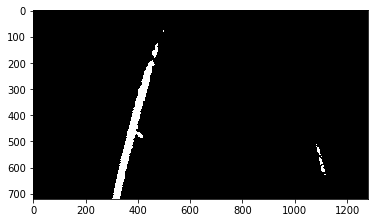

In [16]:
filename = '../test_images/test12.jpg'
test0 = mpread(filename)
plt.imshow(test0)

test1 = cv2.undistort(test0, mtx, dist, None, mtx)
test2 = cv2.warpPerspective(test1, M, (test1.shape[1], test1.shape[0]), flags=cv2.INTER_LINEAR)
test3 = get_threshold_img(test2, rawtype = 'rgb')
test3 = gray_img(test3)
plt.imshow(test3,cmap = 'gray')

In [19]:
def get_histogram(img):
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # as in the persepctive transformation, we have already changed the bottom half to the whole image,
    # then no need to only use the bottom half, just use the whole half
    # but actually when we detect the base lane x-position, we had better consider the bottom half as the lan maybe curving
    histogram = np.sum( img[img.shape[0]//2:,:], axis=0)
    out_img = np.dstack((img, img, img))   
    return histogram

In [20]:
# img_basic is the combined binary image we will do lane finding

# histogram = get_histogram(img_basic1)
# histogram = get_histogram(img_basic2)
# histogram = get_histogram(img_basic3)
# histogram = get_histogram(img_basic4)
# histogram = get_histogram(img_basic5)
histogram = get_histogram(img_basic6)

### using the binary image to get the xm_per_pix and ym_per_pix


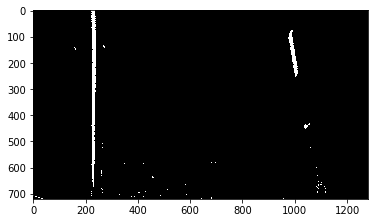

In [21]:
import os
def get_xm_per_pix():
    # we use a straight line img, e.g., test_imgs/straignt_lines1.jpg for calc
    # 1. do un-distortion
    # 2. perspective change
    # 3. get the left and right lane distance by pixel
    # 4. comparing with the real value, we assume 3.5m, 
    # return the xm_per_pix
    imgname = os.path.join('..', 'test_images', 'straight_lines1.jpg')
    img = mpread(imgname)
    img_size = img.shape[1], img.shape[0]
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    warped = cv2.warpPerspective(dst, M, img_size, flags=cv2.INTER_LINEAR)
    gray = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)
    
    color_thresh = (170, 255)
    sobel_thresh = (20, 100)
    
    sobelx = Sobel(gray, cv2.CV_64F, 1, 0)
    sobelx = np.uint8(255*sobelx/np.max(sobelx))
    sobel_bin = np.zeros_like(sobelx)
    sobel_bin[(sobelx >= sobel_thresh[0]) & (sobelx <= sobel_thresh[1])] = 255

    
    hls = cv2.cvtColor(warped, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    
    plt.imshow(sobel_bin, cmap = 'gray')
    hist = get_histogram(sobel_bin)
    
    midpoint = np.int(hist.shape[0]/2)
    leftx_base = np.argmax(hist[:midpoint])
    rightx_base = np.argmax(hist[midpoint:]) + midpoint
    lane_line_pixel = rightx_base - leftx_base
    lane_line_meter = 3.7
    xm_per_pixel = lane_line_meter / lane_line_pixel
    return xm_per_pixel
xm_per_pixel = get_xm_per_pix()        

Sliding Window

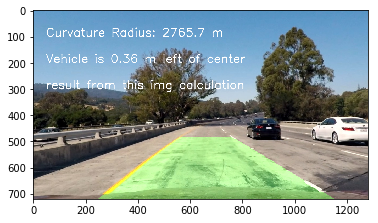

In [77]:
handler = LaneLineHandler()
result = handler.run(img_raw1)
plt.imshow(result)

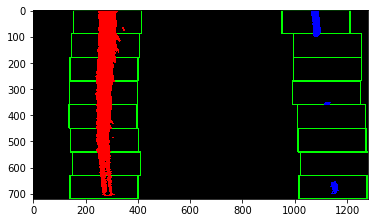

In [78]:
 handler.showOutImg()

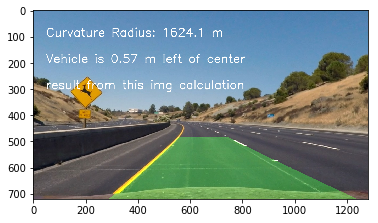

In [79]:
handler = LaneLineHandler()
result = handler.run(img_raw2)
plt.imshow(result)

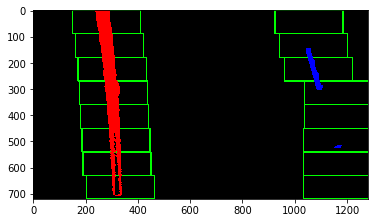

In [80]:
handler.showOutImg()

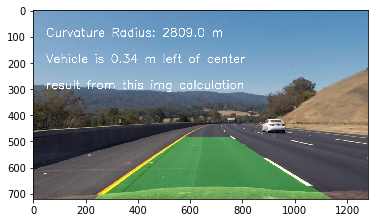

In [81]:
handler = LaneLineHandler()
result = handler.run(img_raw3)
plt.imshow(result)

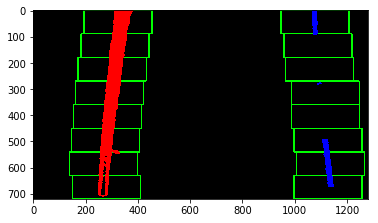

In [82]:
handler.showOutImg()

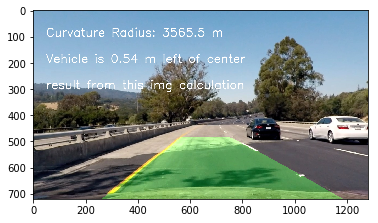

In [83]:
handler = LaneLineHandler()
result = handler.run(img_raw4)
plt.imshow(result)

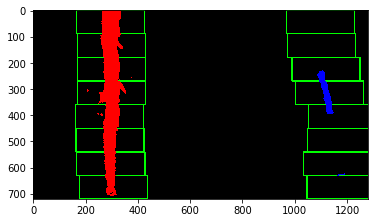

In [84]:
handler.showOutImg()

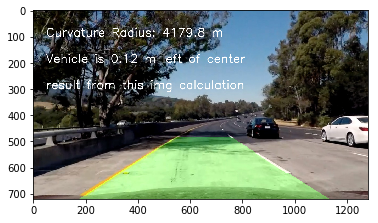

In [50]:
handler = LaneLineHandler()
result = handler.run(img_raw5)
plt.imshow(result)

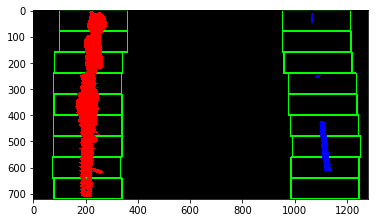

In [51]:
handler.showOutImg()

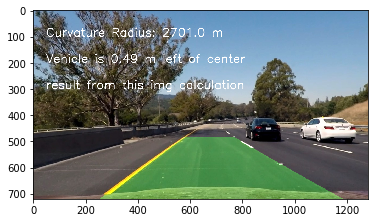

In [52]:
handler = LaneLineHandler()
result = handler.run(img_raw6)
plt.imshow(result)

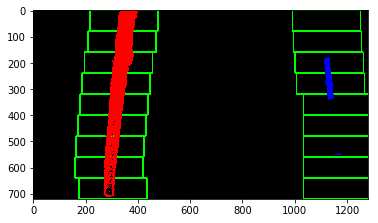

In [53]:
handler.showOutImg()

### 7. Warp the detected lane boundaries back onto the original image.

### 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### 9. final pipe line function

In [68]:
# function for video handling
def process_image(img):
    handler = LaneLineHandler()
    result = handler.run(img)
    return result

handling img  ..\test_images\test1.jpg
handling img  ..\test_images\test2.jpg
handling img  ..\test_images\test3.jpg
handling img  ..\test_images\test4.jpg
handling img  ..\test_images\test5.jpg
handling img  ..\test_images\test6.jpg


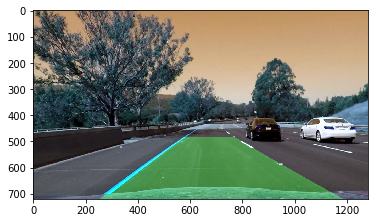

In [69]:
# imgnames = glob.glob('../test_images/test?.jpg')
# for imgname in imgnames:
for idx in range(1, 7):
    oldfilename = os.path.join('..', 'test_images', 'test' + str(idx) + '.jpg')
    newfilename = os.path.join('..', 'output_images', 'test' + str(idx) + '.jpg')
    print('handling img ', oldfilename)
    # dirname, filename = os.path.split(imgname)
    #newimgname = os.path.join('../output_images', filename)
    img = mpread(oldfilename)
    result = process_image(img)
#     plt.imshow(result)
    mpsave(newfilename, result)
#     cv2.imwrite(newfilename, result)             

# pipe line for video

In [28]:
# we use a class to collect all the variables together in a scope

# use it as global as it not changed [y_pixdels, x_pixels]
imgsize = img_basic6.shape[:2]
print(imgsize)

# the difference between LaneLineHandler2 and laneLineHandler is 
# LaneLineHander2 use the previous img left_x_base as the starting point for windows sliding
# while LaneLineHandler use histogram to detect the starting point
class LaneLineHandler2(object):
    def __init__(self, saved_dir = None):
        self.nwindows = 8
        self.window_height = np.int(imgsize[0]/self.nwindows)
        self.margin = 50
        # self.minpix = 50
        self.ym_per_pix = 30./720 # meters per pixel in y dimension
        self.xm_per_pix = 3.7/700
    
        self.mtx = mtx
        self.dist = dist
        self.reuse_count = 0
        
        self.saved_dir = saved_dir
        self.img_count = 0
        self.nodata = False
        
        # for senalty check
        self.last_offset = None
        self.last_left_curvature_meter = None
        self.last_right_curvature_meter = None
        
        self.last_left_fittings = [[], [], [] ]
        self.last_right_fittings = [[], [], []]
        
        self.last_left_fittings_meter = [[], [], [] ]
        self.last_right_fittings_meter = [[], [], []]
        
    def run(self, img):
        self.readin(img)
        self.finding_pixels()
        self.fitting()
        result = self.drawBack()
        return result

        
    def readin(self, img, rawtype = 'rgb'):
        def get_threshold_bin_img(img):
            # for video pipeline, the readin img is RGB format
            b_channel = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)[:,:,2]
            l_channel = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)[:,:,0]  
            # Set the upper and lower thresholds for the b channel
            b_thresh_min = 145
            b_thresh_max = 200
            b_binary = np.zeros_like(b_channel)
            b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1

            # Set the upper and lower thresholds for the l channel
            l_thresh_min = 215
            l_thresh_max = 255
            l_binary = np.zeros_like(l_channel)
            l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

            combined_binary = np.zeros_like(b_binary)
            combined_binary[(l_binary == 1) | (b_binary == 1)] = 1
            return combined_bin
    
        def blind_search(img, nwins):
            left_xvals = []
            left_yvals = []
            right_xvals = []
            right_yvals = []
            xsize, ysize = img.shape[1], img.shape[0]
            xmid = xsize/2
            height = np.int(ysize /nwins) 
            x,y = np.nonzero(np.transpose(img))
            for win in range(nwins):
                # loop from img top to bottom
                histogram = np.sum(img[win * height: (win+1)*height, :], axis = 0)
                left_peak = np.argmax(histogram[:xmid])
                right_peak = np.argmax(histogram[xmid:]) + xmid

                left_x_idx = np.where((((left_peak - 25) < x) & 
                                       (x < (left_peak + 25)) &
                                       ((y > win*height) & (y < (win+1)* height))))
                right_x_idx = np.where((((right_peak - 25) < x) & 
                                       (x < (right_peak + 25)) &
                                       ((y > win*height) & (y < (win+1)* height))))
                left_x_window, left_y_window = x[left_x_idx], y[left_x_idx]
                right_x_window, right_y_window = x[right_x_inx], y[right_x_idx]
                if np.sum(left_x_window) != 0:
                    left_xvals.extend(left_x_window)
                    left_yvals.extend(left_y_window)
                if np.sum(right_x_window) != 0:
                    right_xvals.extend(right_x_window)
                    right_yvals.extend(right_y_widnow)
                    
            # return the x points, y points, and a flag 
            return left_xvals, left_yvals, right_xvals, right_yvals
        
        def based_on_previous_search(img, left_fittings, right_fittings, nwins):
            # here left_fittings[0], left_fittings[1], left_fittings[2] store previous fitting frame img value
            left_xvals = []
            left_yvals = []
            right_xvals = []
            right_yvals = []
            xsize, ysize = img.shape[1], img.shape[0]
            xmid = xsize/2
            height = np.int(ysize /nwins) 
            x,y = np.nonzero(np.transpose(img))
            for win in range(nwins):
                #loop from top to down
                ymid = np.mean([win * height, (win +1) * height])
                
                left_xmid = (np.mean(left_fittings[0]))*ymid**2 +(np.mean(left_fittings[1]))*ymid + (np.mean(left_fittings[2]))
                right_xmid = (np.mean(right_fittings[0]))*ymid**2 + (np.mean(right_fittings[1]))*ymid + (np.mean(right_fittings[2]))
                
                left_x_idx = np.where((((left_xmid - 25) < x) & (x < (left_xmid + 25))&((y > win*height) & (y < (win+1) * height))))
                right_x_idx = np.where((((right_xmid - 25) < x) & (x < (right_xmid + 25))&((y > win*height) & (y < (win+1) * height))))
               
                left_x_window, left_y_window = x[left_x_idx], y[left_x_idx]
                right_x_window, right_y_window = x[right_x_idx], y[right_x_idx]
                if np.sum(left_x_window) != 0:
                    np.append(left_xvals, left_x_window)
                    np.append(left_yvals, left_y_window)
                if np.sum(right_x_window) != 0:
                    np.append(right_xvals, right_x_window)
                    np.append(right_yvals, right_y_window)
            return left_xvals, left_yvals, right_xvals, right_yvals
    
    
        # readin the raw color image taken from the camera
        self.img_count += 1
        img = cv2.undistort(img, self.mtx, self.dist, None, self.mtx)
        self.img_raw = img
        self.nodata = False
        
        if self.saved_dir != None:
            filename = self.saved_dir + str(self.img_count) + '_0raw.jpg'
            mpsave(filename, self.img_raw)
        
        self.img_warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
        self.img_basic = get_threshold_bin_img(self.img_warped)
        x, y = np.nonzeros(np.transpose(self.img_basic))
        if len(x) == 0:
            print('no data for fitting, using previous img')
            self.nodata = True
        return

    
    def finding_pixels(self):
        # we use different strategy to do searching
        if self.nodata == True:
            self.leftx, self.lefty, self.rightx, self.righty = [], [], [], []
        elif self.reuse_count >= 6 or self.img_count == 1:
            # the first img or too many reuse
            self.leftx, self.lefty, self.rightx, self.righty = blind_search(self.img_basic, 
                                                                            self.nwindows)
        else:
            self.leftx, self.lefty, self.rightx, self.righty = based_on_previous_search(self.img_basic, 
                                                                                        self.last_left_fittings,
                                                                                        self.last_right_fittings,
                                                                                        self.nwindows)
            if len(self.leftx) == 0 or len(self.rightx) == 0:
                self.leftx, self.lefty, self.rightx, self.righty = blind_search(self.img_basic,
                                                                               self.nwindows)
            
    def senaltyCheck(self):
        if self.reuse_count > 6:
            reuse = False
        elif self.last_offset == None:
            reuse = False
        else:
            reuse = False
            if self.nodata == True:
                print('no data, reuse previous data')
                reuse = True
            elif abs(self.last_offset - self.offset) > 0.2:
                print('resue previous, as last_offset =', self.last_offset, ' this offset =', self.offset )
                resue = True
            elif abs(self.last_left_curvature_meter - self.left_curvature_meter) > 500:
                print('last left curvature meter = ', self.last_left_curvature_meter, 
                      ' this is=', self.left_curvature_meter)
                reuse = True
            elif abs(self.last_right_curvature_meter - self.right_curvature_meter) > 500:
                print('last right curvature meter =', self.last_right_curvature_meter, 
                      ' this is=', self.right_curvature_meter)
                reuse = True
                
        if reuse == True:
            self.reuse_count += 1
            self.offset = self.last_offset
            self.left_curvature_meter = self.last_left_curvature_meter
            self.right_curvature_meter = self.last_right_curvature_meter
            assert len(self.last_left_fittings[0]) >= 1
            assert len(self.last_right_fittings[0]) >= 1
            self.left_fit = [ self.last_left_fittings[0][-1],
                            self.last_left_fittings[1][-1],
                            self.last_left_fittings[2][-1]]
            
            self.right_fit = [ self.last_right_fittings[0][-1],
                             self.last_right_fittings[1][-1],
                             self.last_right_fittings[2][-1]]
            self.left_fit_meter = [ self.last_left_fittings_meter[0][-1],
                                   self.last_left_fittings_meter[1][-1],
                                   self.last_left_fittings_meter[2][-1]]
            
            self.right_fit_meter = [ self.last_right_fittings_meter[0][-1],
                                    self.last_right_fittings_meter[1][-1],
                                    self.last_right_fittings_meter[2][-1]]
                
        else:
            self.reuse_count = 0
            self.last_offset = self.offset
            self.last_left_curvature_meter = self.left_curvature_meter
            self.last_right_curvature_meter = self.right_curvature_meter
            for i in range(3):
                self.last_left_fittings[i].append(self.left_fit[i])
                self.last_right_fittings[i].append(self.right_fit[i])
                if len(self.last_left_fittings[i]) > 4:
                    self.last_left_fittings[i] = self.last_left_fittings[i][-4:]
                if len(self.last_right_fittings[i]) > 4:
                    self.last_right_fittings[i] = self.last_right_fittings[i][-4:]
                
                self.last_left_fittings_meter[i].append(self.left_fit_meter[i])
                self.last_right_fittings_meter[i].append(self.right_fit_meter[i])
                if len(self.last_left_fittings_meter[i]) > 4:
                    self.last_left_fittings_meter[i] = self.last_left_fittings_meter[i][-4:]
                if len(self.last_right_fittings_meter[i]) > 4:
                    self.last_right_fittings_meter[i] = self.last_right_fittings_meter[i][-4:]
                    

        
    def fitting(self):
        # no data for current, then do re-use previous frame img pixels
        if len(self.leftx) == 0:
            self.leftx = self.last_leftx
            self.lefty = self.last_lefty
        if len(self.rightx) == 0:
            self.rightx = self.last_rightx
            self.righty = self.last_righty
                
        # Fit a second order polynomial to each
        self.left_fit = np.polyfit(self.lefty, self.leftx, 2)
        self.right_fit = np.polyfit(self.righty, self.rightx, 2)
        
        self.left_fit_meter = np.polyfit(self.lefty * self.ym_per_pix, self.leftx * self.xm_per_pix, 2)
        self.right_fit_meter = np.polyfit(self.righty * self.ym_per_pix, self.rightx * self.xm_per_pix, 2)

    
    def calcOffset(self):
        car_left = self.left_fit[0]*720**2 + self.left_fit[1]*720 + self.left_fit[2]
        car_right = self.right_fit[0]*720**2 + self.right_fit[1]*720 + self.right_fit[2]
        car_center = (car_left + cat_right) /2.0
        self.offset = (car_center - 640)* self.xm_per_pix
        
    def calcCurvature(self):
        ploty = np.linspace(0, self.img_basic.shape[0]-1, self.img_basic.shape[0] )

        y_eval = np.max(ploty)
        # calc the curvature at the bottom,e.g., close to the car
        # x = a*y^2 + b*y + c 
        # R_curve = [1 + (2a+b)^2]^(3/2)/ |2a|


        self.left_curvature = ((1 + (2*self.left_fit[0]*y_eval + self.left_fit[1])**2)**1.5) / np.absolute(2*self.left_fit[0])
        self.right_curvature= ((1 + (2*self.right_fit[0]*y_eval + self.right_fit[1])**2)**1.5) / np.absolute(2*self.right_fit[0])
        
        left_fitting0 = np.mean(self.last_left_fittings[0])
        left_fitting1 = np.mean(self.last_left_fittings[1])
        left_fitting2 = np.mean(self.last_left_fittings[2])
        self.left_curvature = ((1 + (2*left_fitting0*y_eval + left_fitting1)**2)**1.5) / np.absolute(2*left_fitting0)
        self.right_curvature= ((1 + (2*right_fitting0*y_eval + right_fitting1)**2)**1.5) / np.absolute(2*right_fitting0)
        
        y_eval = y_eval * self.ym_per_pix
        self.left_curvature_meter =((1 + (2*self.left_fit_meter[0]* y_eval + self.left_fit_meter[1])**2)**1.5) / np.absolute(2*self.left_fit_meter[0])
        self.right_curvature_meter = ((1 + (2*self.right_fit_meter[0] * y_eval + self.right_fit_meter[1])**2)**1.5) / np.absolute(2*self.right_fit_meter[0])
        
        left_fitting0 = np.mean(self.last_left_fittings_meter[0])
        left_fitting1 = np.mean(self.last_left_fittings_meter[1])
        left_fitting2 = np.mean(self.last_left_fittings_meter[2])
        self.left_curvature_meter =((1 + (2*left_fitting0* y_eval + left_fitting1)**2)**1.5) / np.absolute(2*left_fitting0)
        self.right_curvature_meter = ((1 + (2*right_fitting0 * y_eval + right_fitting1)**2)**1.5) / np.absolute(2*right_fitting0)
        
    
    def drawBack(self):
        if self.saved_dir != None:
            filename = self.saved_dir + str(self.img_count) + '_0raw.jpg'
            mpsave(filename, self.img_raw)
            

        # Create an image to draw the lines on
        color_warp = np.zeros_like(self.img_raw).astype(np.uint8)
        
        ploty = np.linspace(0, self.img_basic.shape[0]-1, self.img_basic.shape[0] )
        
        self.calcOffset()
        self.calcCurvature()
        self.senaltyCheck()

        left_fitting0
        left_fitx = self.left_fit[0]*ploty**2 + self.left_fit[1]*ploty + self.left_fit[2]
        right_fitx = self.right_fit[0]*ploty**2 + self.right_fit[1]*ploty + self.right_fit[2]

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (self.img_basic.shape[1], self.img_basic.shape[0])) 
        
        # Combine the result with the original image
        result = cv2.addWeighted(self.img_raw, 1, newwarp, 0.3, 0)
        # plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        
        # write the curvature and position information
        font = cv2.FONT_HERSHEY_SIMPLEX
                
        text = 'Curvature Radius: '+ '{0:.1f}'.format(self.left_curvature_meter/2.0 + self.right_curvature_meter/2.0 ) + ' m'
        cv2.putText(result, text, (50,100), font, 1.5, (255,255,255),2, cv2.LINE_AA)

    
        if self.offset > 0:
            text = 'Vehicle is ' + '{0:.2f}'.format(self.offset) + ' m left of center'
        else:
            text = 'Vehicle is ' + '{0:.2f}'.format(- self.offset) + ' m right of center' 
        cv2.putText(result, text, (50,200), font, 1.5, (255,255,255),2, cv2.LINE_AA)
        
        if self.reuse_count == 0:
            text = 'result from this img calculation'
        else:
            text = 'reuse previous img info, reuse count = ' + str(self.reuse_count)
        cv2.putText(result, text, (50, 300), font, 1.5, (255, 255, 255), 2, cv2.LINE_AA)

        if self.saved_dir != None:
            filename = self.saved_dir + str(self.img_count) + '_1warped.jpg'
            cv2.imwrite(filename, self.img_warped)
            filename = self.saved_dir + str(self.img_count) + '_2basic.jpg'
            cv2.imwrite(filename, self.img_basic)
            filename = self.saved_dir + str(self.img_count) + '_3fitting.jpg'
            cv2.imwrite(filename, self.out_color)
            
        return result

(720, 1280)


In [25]:
g_handler2 = LaneLineHandler2()
def get_handler2():
    return g_handler2

In [26]:
def process_image2(img):
    handler = get_handler2()
    result = handler.run(img)
    return result

[MoviePy] >>>> Building video ../project_solution.mp4
[MoviePy] Writing video ../project_solution.mp4


 35%|███▍      | 9/26 [00:02<00:04,  3.96it/s]

no data for fitting...
no data


 96%|█████████▌| 25/26 [00:06<00:00,  3.92it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../project_solution.mp4 

Wall time: 7.23 s


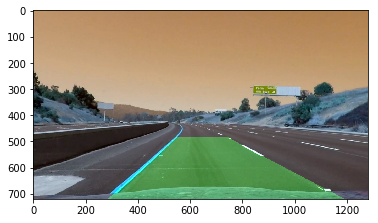

In [27]:
from moviepy.editor import VideoFileClip
video_input = '../project_video.mp4'
video_output = '../project_solution.mp4'
# challenge_output = 'test_videos_output/challenge.mp4'

# g_handler2 = LaneLineHandler2('../videoimg_project/')
g_handler2 = LaneLineHandler2()

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
# clip1 = VideoFileClip(video_input)
clip1 = VideoFileClip(video_input).subclip(0,1)
# clip1 = VideoFileClip(video_input)
challenge_clip = clip1.fl_image(process_image2)
%time challenge_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video ../challenge_solution.mp4
[MoviePy] Writing video ../challenge_solution.mp4


  1%|          | 6/485 [00:01<01:52,  4.26it/s]

no data for fitting...
no data


  1%|▏         | 7/485 [00:01<01:51,  4.30it/s]

no data for fitting...
no data


  2%|▏         | 8/485 [00:01<01:54,  4.17it/s]

no data for fitting...
no data


  2%|▏         | 9/485 [00:02<01:53,  4.20it/s]

no data for fitting...
no data


  2%|▏         | 10/485 [00:02<02:03,  3.85it/s]

no data for fitting...
no data


  2%|▏         | 11/485 [00:02<02:06,  3.76it/s]

no data for fitting...
no data


  2%|▏         | 12/485 [00:03<02:11,  3.60it/s]

no data for fitting...
no data


  7%|▋         | 35/485 [00:08<01:42,  4.40it/s]

no data for fitting...
no data


 27%|██▋       | 133/485 [00:32<01:18,  4.47it/s]

no data for fitting...
no data


 28%|██▊       | 134/485 [00:33<01:20,  4.36it/s]

no data for fitting...
no data


 28%|██▊       | 135/485 [00:33<01:24,  4.14it/s]

no data for fitting...
no data


 28%|██▊       | 136/485 [00:33<01:26,  4.05it/s]

no data for fitting...
no data


 28%|██▊       | 137/485 [00:34<01:25,  4.06it/s]

no data for fitting...
no data


 28%|██▊       | 138/485 [00:34<01:26,  4.00it/s]

no data for fitting...
no data


 29%|██▊       | 139/485 [00:34<01:28,  3.93it/s]

no data for fitting...
no data


 29%|██▉       | 140/485 [00:34<01:27,  3.95it/s]

no data for fitting...


 29%|██▉       | 141/485 [00:35<01:25,  4.04it/s]

no data for fitting...
no data


 29%|██▉       | 142/485 [00:35<01:26,  3.98it/s]

no data for fitting...
no data


 29%|██▉       | 143/485 [00:35<01:26,  3.96it/s]

no data for fitting...
no data


 30%|██▉       | 144/485 [00:35<01:24,  4.04it/s]

no data for fitting...
no data


 30%|██▉       | 145/485 [00:36<01:24,  4.02it/s]

no data for fitting...
no data


 30%|███       | 146/485 [00:36<01:23,  4.07it/s]

no data for fitting...
no data


 30%|███       | 147/485 [00:36<01:23,  4.04it/s]

no data for fitting...
no data


 31%|███       | 148/485 [00:36<01:22,  4.10it/s]

no data for fitting...


 31%|███       | 149/485 [00:36<01:21,  4.10it/s]

no data for fitting...
no data


 31%|███       | 150/485 [00:37<01:22,  4.08it/s]

no data for fitting...
no data


 31%|███       | 151/485 [00:37<01:24,  3.95it/s]

no data for fitting...
no data


 31%|███▏      | 152/485 [00:37<01:21,  4.11it/s]

resue previous, as last_offset = -1.55928571429  this offset = 0.309214285714


 50%|████▉     | 242/485 [01:00<01:02,  3.89it/s]

no data for fitting...
no data


 67%|██████▋   | 326/485 [01:20<00:37,  4.28it/s]

no data for fitting...
no data


 67%|██████▋   | 327/485 [01:20<00:37,  4.17it/s]

no data for fitting...
no data


 68%|██████▊   | 328/485 [01:20<00:37,  4.20it/s]

no data for fitting...
no data


 70%|██████▉   | 339/485 [01:23<00:34,  4.24it/s]

no data for fitting...
no data


 70%|███████   | 341/485 [01:23<00:34,  4.13it/s]

no data for fitting...
no data


 73%|███████▎  | 353/485 [01:26<00:31,  4.18it/s]

no data for fitting...
no data


 73%|███████▎  | 354/485 [01:26<00:31,  4.15it/s]

no data for fitting...
no data


 73%|███████▎  | 355/485 [01:27<00:30,  4.20it/s]

no data for fitting...
no data


 76%|███████▌  | 367/485 [01:30<00:29,  3.95it/s]

no data for fitting...
no data


 76%|███████▌  | 368/485 [01:30<00:29,  4.02it/s]

no data for fitting...
no data


 79%|███████▊  | 381/485 [01:33<00:26,  3.97it/s]

no data for fitting...
no data


 79%|███████▉  | 382/485 [01:33<00:26,  3.94it/s]

no data for fitting...
no data


 81%|████████▏ | 395/485 [01:36<00:21,  4.14it/s]

no data for fitting...
no data


 84%|████████▍ | 409/485 [01:40<00:18,  4.10it/s]

no data for fitting...
no data


 85%|████████▍ | 410/485 [01:40<00:18,  4.08it/s]

no data for fitting...
no data


 90%|████████▉ | 436/485 [01:46<00:11,  4.19it/s]

no data for fitting...
no data


 90%|█████████ | 437/485 [01:46<00:11,  4.19it/s]

no data for fitting...
no data


 90%|█████████ | 438/485 [01:47<00:11,  4.23it/s]

no data for fitting...
no data


 93%|█████████▎| 450/485 [01:49<00:08,  4.19it/s]

no data for fitting...
no data


 99%|█████████▊| 478/485 [01:57<00:02,  3.44it/s]

no data for fitting...
no data


 99%|█████████▉| 479/485 [01:57<00:01,  3.63it/s]

no data for fitting...
no data


 99%|█████████▉| 480/485 [01:58<00:01,  3.71it/s]

no data for fitting...
no data


 99%|█████████▉| 481/485 [01:58<00:01,  3.59it/s]

no data for fitting...
no data


 99%|█████████▉| 482/485 [01:58<00:00,  3.60it/s]

no data for fitting...
no data


100%|██████████| 485/485 [01:59<00:00,  3.68it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../challenge_solution.mp4 

Wall time: 2min


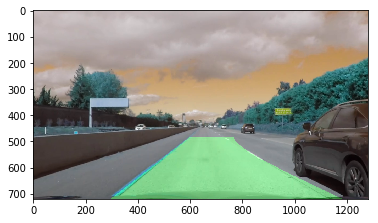

In [75]:

from moviepy.editor import VideoFileClip
challenge_input = '../challenge_video.mp4'
challenge_output = '../challenge_solution.mp4'
# challenge_output = 'test_videos_output/challenge.mp4'

# renew handler
# g_handler2 = LaneLineHandler2('../videoimg_challenge/')
g_handler2 = LaneLineHandler2()

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip2 = VideoFileClip(challenge_input)
# clip2 = VideoFileClip(challenge_input).subclip(0, 2)
challenge_clip = clip2.fl_image(process_image2)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
from moviepy.editor import VideoFileClip
harder_challenge_input = '../harder_challenge_video.mp4'
harder_challenge_output = '../harder_challenge_solution.mp4'

# renew handler
g_handler2 = LaneLineHandler2('../videoimg_harder/')

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
# clip3 = VideoFileClip(harder_challenge_input)
clip3 = VideoFileClip(harder_challenge_input).subclip(24, 27)

challenge_clip = clip3.fl_image(process_image2)
%time challenge_clip.write_videofile(harder_challenge_output, audio=False)